In [1]:
from CherryTreeDataset import CherryTreeDataset
from torchvision import transforms
from funciones_auxiliares import plot_spectra, analyze_image, analyze_tiff_metadata, PATH, crop_central_region, set_seed, seed_worker
from resnet_adapters import adapt_resnet_channels
import torch
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, SqueezeNet1_1_Weights, ResNet101_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import os
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

set_seed(42)
g = torch.Generator()
g.manual_seed(42)

Semillas aleatorias configuradas a: 42


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'El dispositivo seleccionado es {device}')

El dispositivo seleccionado es cuda


In [5]:
# Define las transformaciones si son necesarias
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.Lambda(lambda x: crop_central_region(x, center_ratio=0.8)),
    transforms.ToTensor()
])

#formats = ( 'RGB.JPG','RED.TIF','GRE.TIF','NIR.TIF','REG.TIF')
formats = ('RGB.JPG','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG',)
dataset = CherryTreeDataset(PATH, transform=transform, formats = formats, concatenate = True, healthy_ratio=5)

# Separa los índices por clase
healthy_indices = []
disease_indices = []

for i, (_, label) in enumerate(dataset.samples):
    if label == 0:  # Healthy
        healthy_indices.append(i)
    else:  # Disease
        disease_indices.append(i)
# Mezcla los índices
np.random.shuffle(healthy_indices)
np.random.shuffle(disease_indices)

# Divide en entrenamiento y prueba (80% - 20%)
train_healthy = healthy_indices[:int(0.8 * len(healthy_indices))]
test_healthy = healthy_indices[int(0.8 * len(healthy_indices)):]

train_disease = disease_indices[:int(0.8 * len(disease_indices))]
test_disease = disease_indices[int(0.8 * len(disease_indices)):]

# Combina los índices
train_indices = np.concatenate([train_healthy, train_disease])
test_indices = np.concatenate([test_healthy, test_disease])

# Mezcla los índices combinados
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Crea los subconjuntos
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Crea los dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=20,  worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=20,  worker_init_fn=seed_worker)

train_healthy_ratio = len(train_healthy) / len(train_indices)
test_healthy_ratio = len(test_healthy) / len(test_indices)

pos_weight = torch.tensor([len(train_healthy) / len(train_disease)]).to(device)

print(f"Ratio de muestras saludables en entrenamiento: {train_healthy_ratio:.4f}")
print(f"Ratio de muestras saludables en prueba: {test_healthy_ratio:.4f}")

In [7]:
#resnet = models.squeezenet1_1(SqueezeNet1_1_Weights.IMAGENET1K_V1)
resnet = models.resnet101(ResNet101_Weights.IMAGENET1K_V1)
#resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

resnet = adapt_resnet_channels(resnet, 5)

print(resnet)

num_classes = 2  # Número de clases en tu dataset

resnet.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(resnet.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

for m in resnet.fc.modules():
    if isinstance(m, nn.Linear):
        # Inicialización He (Kaiming) para capas con ReLU
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu', generator=torch.Generator().manual_seed(42))
        # Inicializar bias en cero (opcional, este es el valor por defecto)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
resnet.to(device)

for param in resnet.parameters():
    param.requires_grad = False


# Descongelar todas las capas en `layer4`
#for param in resnet.layer4.parameters():
#    param.requires_grad = True
#for param in resnet.layer3.parameters():
#    param.requires_grad = True
#for param in resnet.conv1.parameters():
#    param.requires_grad = True

# Descongelar la capa `avgpool` y `fc`
for param in resnet.avgpool.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

#print(resnet)
#for name, param in resnet.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")



/home/chris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/chris/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|████████████████████████████████████████████████████████████████████████████████| 171M/171M [00:03<00:00, 46.5MB/s]


ResNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

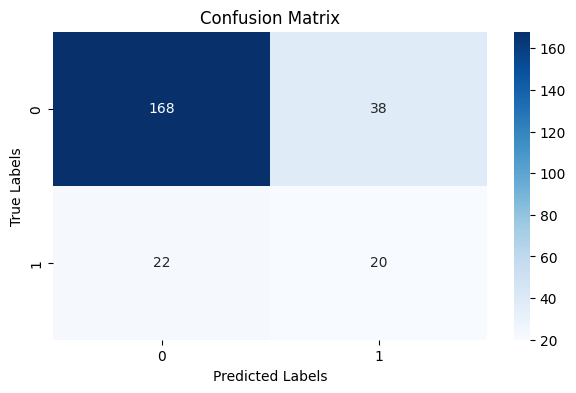

Precision: 0.3448, Recall: 0.4762, F1-Score: 0.4000
AUC-ROC: 0.5543
Epoch [1/100], Train Loss: 1.2915, Validation Loss: 1.0758, Accuracy: 75.81%


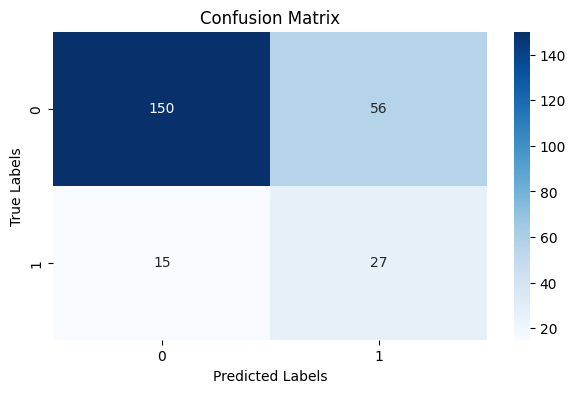

Precision: 0.3253, Recall: 0.6429, F1-Score: 0.4320
AUC-ROC: 0.6011
Epoch [2/100], Train Loss: 1.2229, Validation Loss: 1.5124, Accuracy: 71.37%


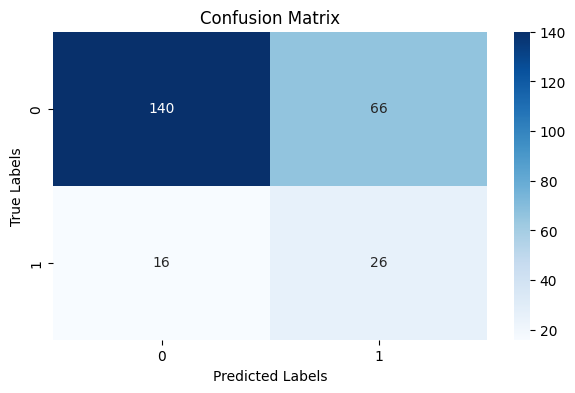

Precision: 0.2826, Recall: 0.6190, F1-Score: 0.3881
AUC-ROC: 0.4857
Epoch [3/100], Train Loss: 1.3428, Validation Loss: 1.5604, Accuracy: 66.94%


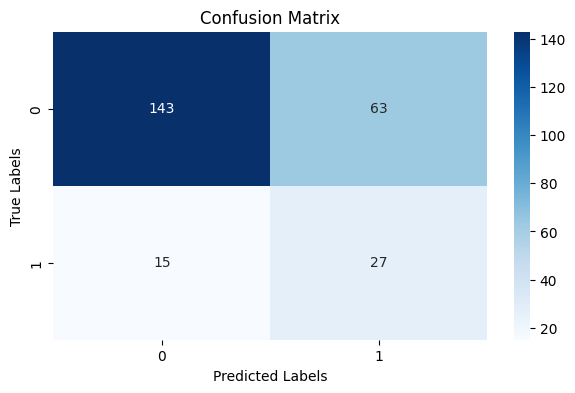

Precision: 0.3000, Recall: 0.6429, F1-Score: 0.4091
AUC-ROC: 0.4614
Epoch [4/100], Train Loss: 1.2798, Validation Loss: 1.6132, Accuracy: 68.55%


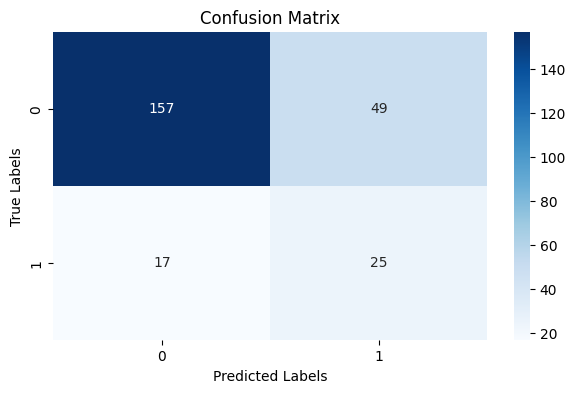

Precision: 0.3378, Recall: 0.5952, F1-Score: 0.4310
AUC-ROC: 0.4769
Epoch [5/100], Train Loss: 1.3747, Validation Loss: 1.5434, Accuracy: 73.39%


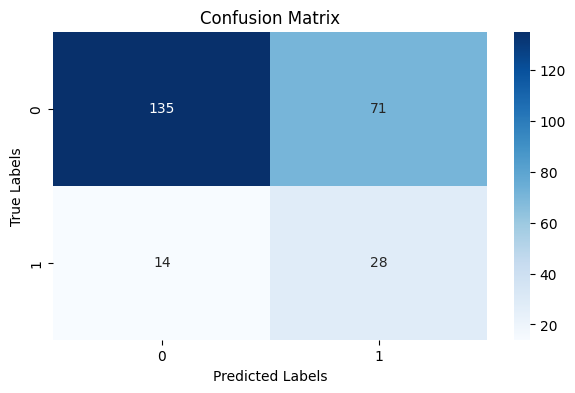

Precision: 0.2828, Recall: 0.6667, F1-Score: 0.3972
AUC-ROC: 0.4560
Epoch [6/100], Train Loss: 1.3377, Validation Loss: 1.6382, Accuracy: 65.73%


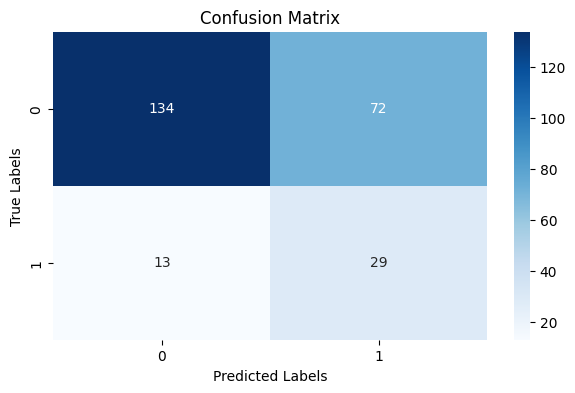

Precision: 0.2871, Recall: 0.6905, F1-Score: 0.4056
AUC-ROC: 0.4665
Epoch [7/100], Train Loss: 1.1748, Validation Loss: 1.9844, Accuracy: 65.73%


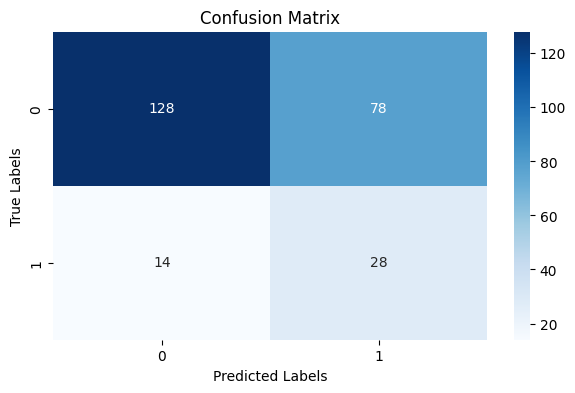

Precision: 0.2642, Recall: 0.6667, F1-Score: 0.3784
AUC-ROC: 0.5244
Epoch [8/100], Train Loss: 1.4085, Validation Loss: 1.8437, Accuracy: 62.90%


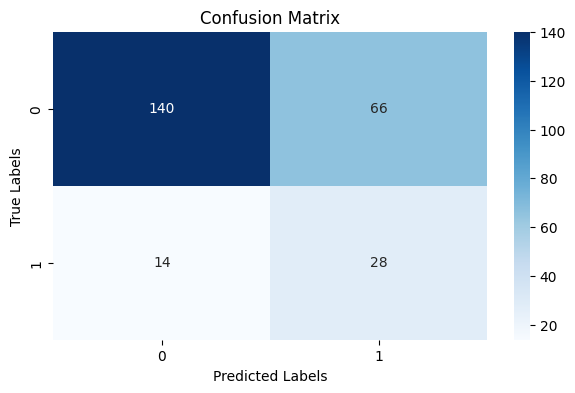

Precision: 0.2979, Recall: 0.6667, F1-Score: 0.4118
AUC-ROC: 0.5764
Epoch [9/100], Train Loss: 1.2328, Validation Loss: 1.6305, Accuracy: 67.74%


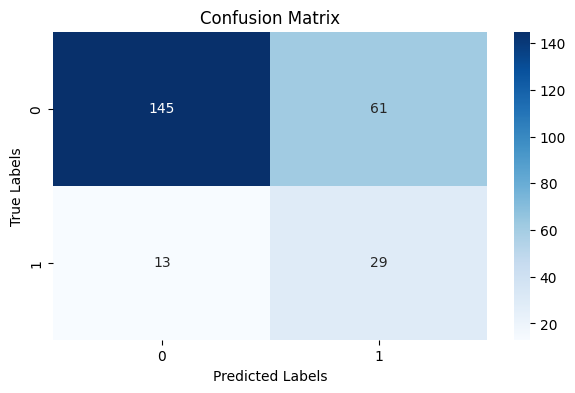

Precision: 0.3222, Recall: 0.6905, F1-Score: 0.4394
AUC-ROC: 0.5391
Epoch [10/100], Train Loss: 1.3448, Validation Loss: 1.4981, Accuracy: 70.16%


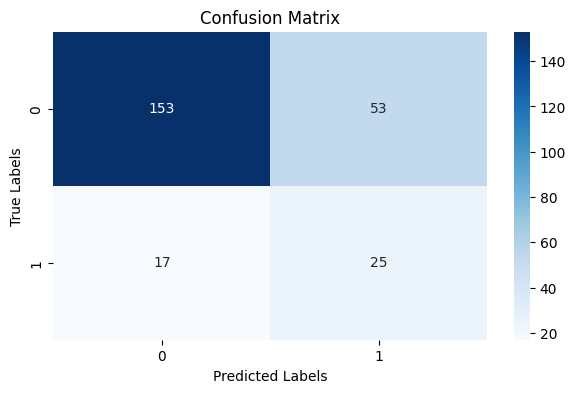

Precision: 0.3205, Recall: 0.5952, F1-Score: 0.4167
AUC-ROC: 0.4888
Epoch [11/100], Train Loss: 1.3033, Validation Loss: 1.3041, Accuracy: 71.77%


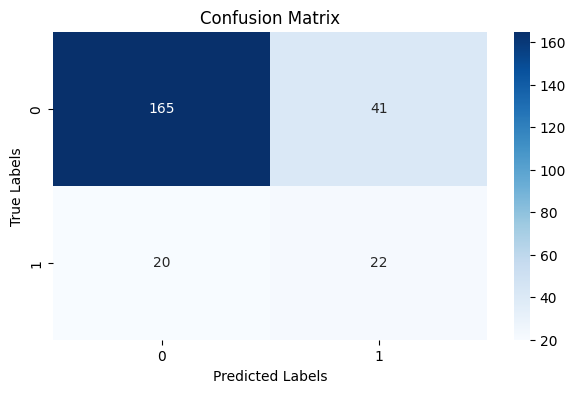

Precision: 0.3492, Recall: 0.5238, F1-Score: 0.4190
AUC-ROC: 0.4887
Epoch [12/100], Train Loss: 1.4150, Validation Loss: 1.1966, Accuracy: 75.40%


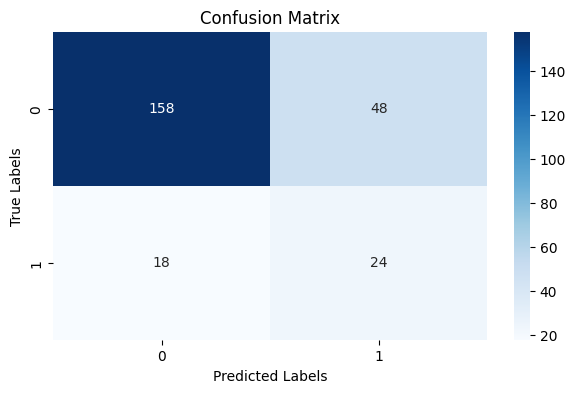

Precision: 0.3333, Recall: 0.5714, F1-Score: 0.4211
AUC-ROC: 0.5039
Epoch [13/100], Train Loss: 1.2928, Validation Loss: 1.2975, Accuracy: 73.39%


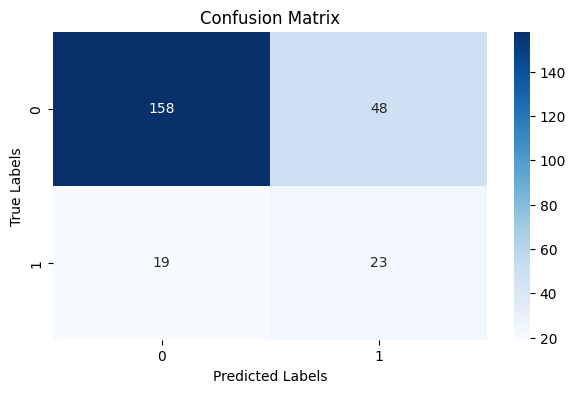

Precision: 0.3239, Recall: 0.5476, F1-Score: 0.4071
AUC-ROC: 0.4267
Epoch [14/100], Train Loss: 1.3570, Validation Loss: 1.2673, Accuracy: 72.98%


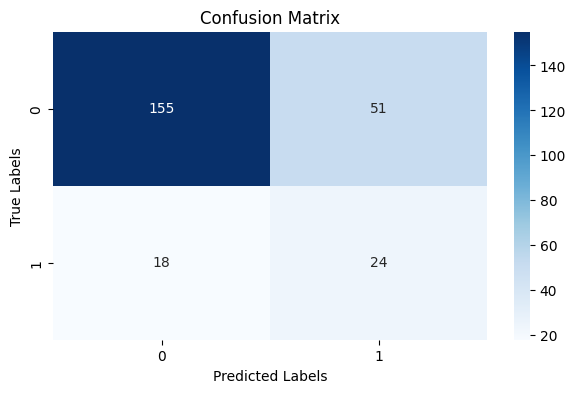

Precision: 0.3200, Recall: 0.5714, F1-Score: 0.4103
AUC-ROC: 0.4156
Epoch [15/100], Train Loss: 1.3943, Validation Loss: 1.3872, Accuracy: 72.18%


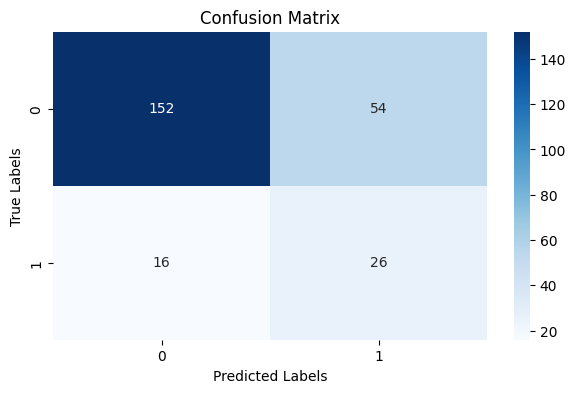

Precision: 0.3250, Recall: 0.6190, F1-Score: 0.4262
AUC-ROC: 0.4233
Epoch [16/100], Train Loss: 1.2839, Validation Loss: 1.4015, Accuracy: 71.77%


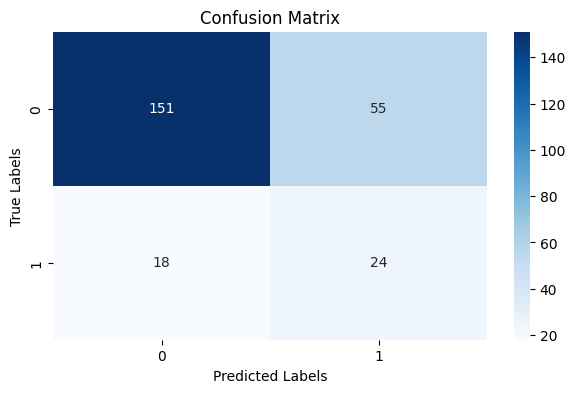

Precision: 0.3038, Recall: 0.5714, F1-Score: 0.3967
AUC-ROC: 0.4764
Epoch [17/100], Train Loss: 1.2908, Validation Loss: 1.5068, Accuracy: 70.56%


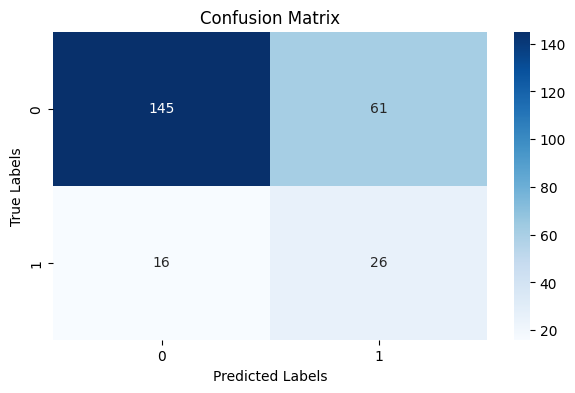

Precision: 0.2989, Recall: 0.6190, F1-Score: 0.4031
AUC-ROC: 0.4479
Epoch [18/100], Train Loss: 1.3225, Validation Loss: 1.5054, Accuracy: 68.95%


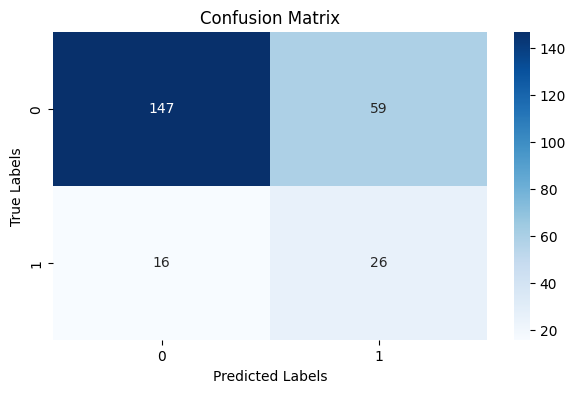

Precision: 0.3059, Recall: 0.6190, F1-Score: 0.4094
AUC-ROC: 0.5681
Epoch [19/100], Train Loss: 1.3487, Validation Loss: 1.4999, Accuracy: 69.76%


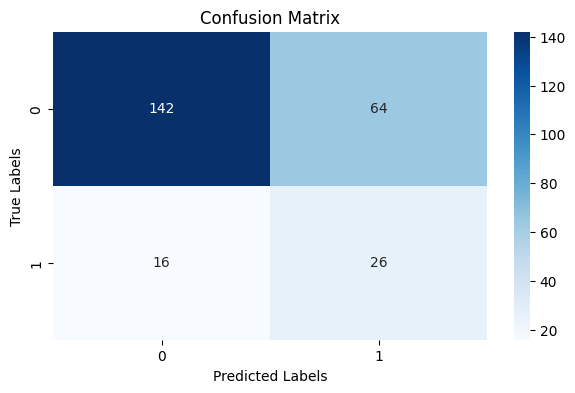

Precision: 0.2889, Recall: 0.6190, F1-Score: 0.3939
AUC-ROC: 0.5063
Epoch [20/100], Train Loss: 1.2050, Validation Loss: 1.5144, Accuracy: 67.74%


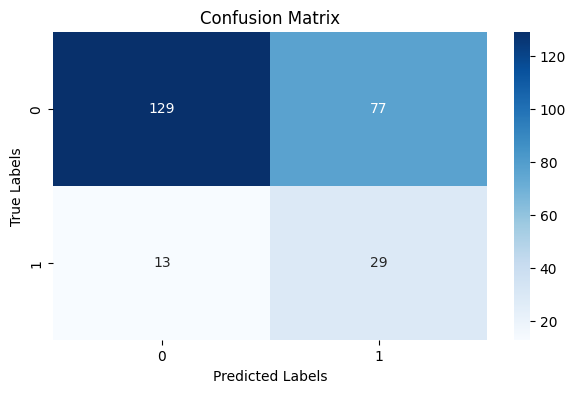

Precision: 0.2736, Recall: 0.6905, F1-Score: 0.3919
AUC-ROC: 0.5380
Epoch [21/100], Train Loss: 1.2517, Validation Loss: 1.6009, Accuracy: 63.71%


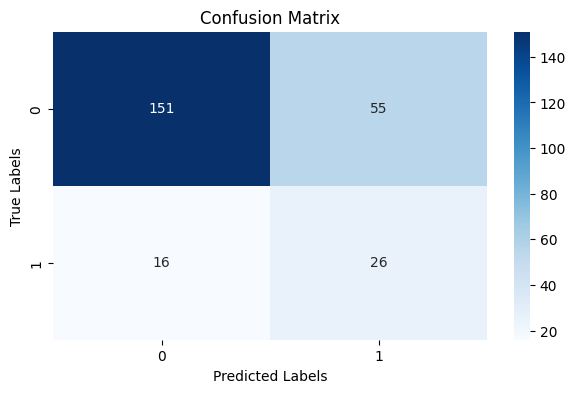

Precision: 0.3210, Recall: 0.6190, F1-Score: 0.4228
AUC-ROC: 0.5198
Epoch [22/100], Train Loss: 1.2714, Validation Loss: 1.5951, Accuracy: 71.37%


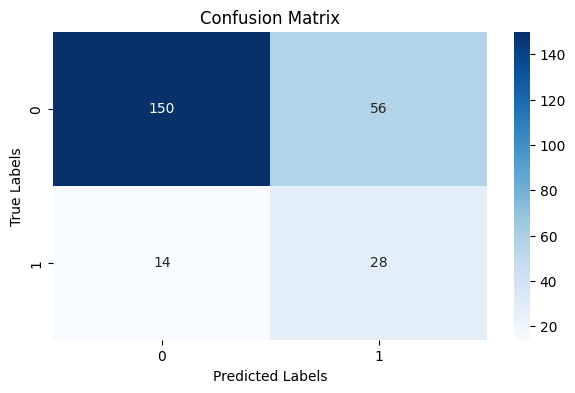

Precision: 0.3333, Recall: 0.6667, F1-Score: 0.4444
AUC-ROC: 0.4671
Epoch [23/100], Train Loss: 1.2243, Validation Loss: 1.2795, Accuracy: 71.77%


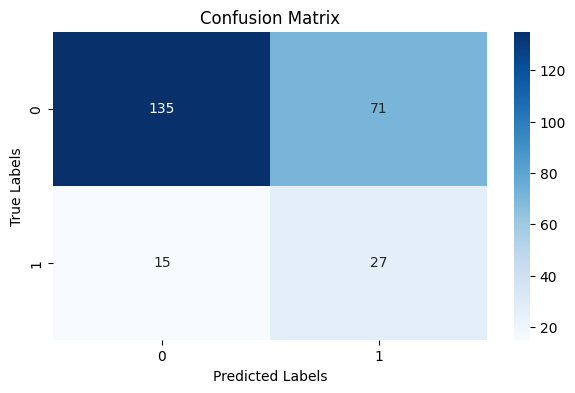

Precision: 0.2755, Recall: 0.6429, F1-Score: 0.3857
AUC-ROC: 0.5187
Epoch [24/100], Train Loss: 1.3257, Validation Loss: 1.7090, Accuracy: 65.32%


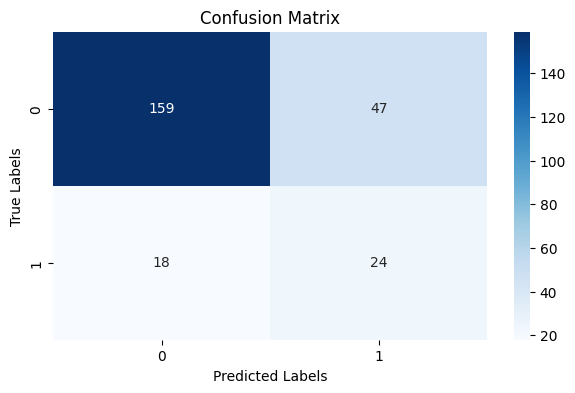

Precision: 0.3380, Recall: 0.5714, F1-Score: 0.4248
AUC-ROC: 0.5116
Epoch [25/100], Train Loss: 1.2214, Validation Loss: 1.5195, Accuracy: 73.79%


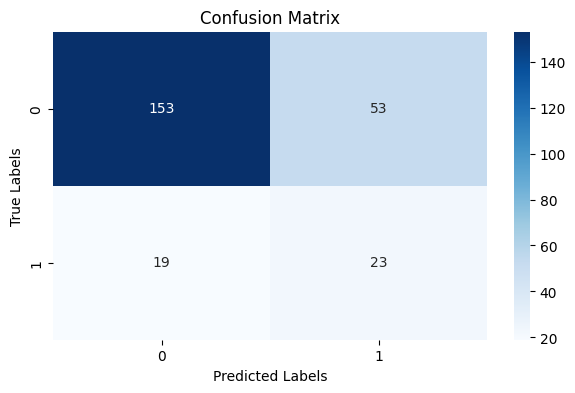

Precision: 0.3026, Recall: 0.5476, F1-Score: 0.3898
AUC-ROC: 0.4665
Epoch [26/100], Train Loss: 1.2828, Validation Loss: 1.3916, Accuracy: 70.97%


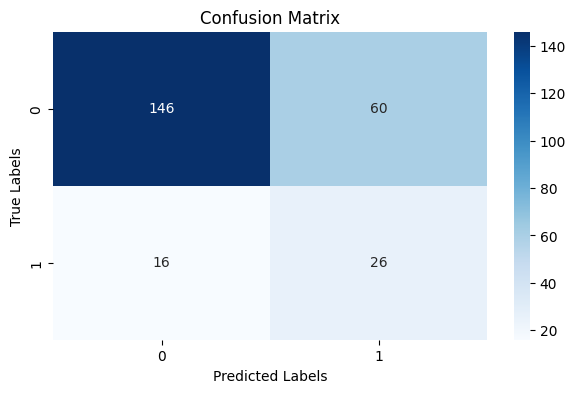

Precision: 0.3023, Recall: 0.6190, F1-Score: 0.4062
AUC-ROC: 0.5065
Epoch [27/100], Train Loss: 1.1664, Validation Loss: 1.6837, Accuracy: 69.35%


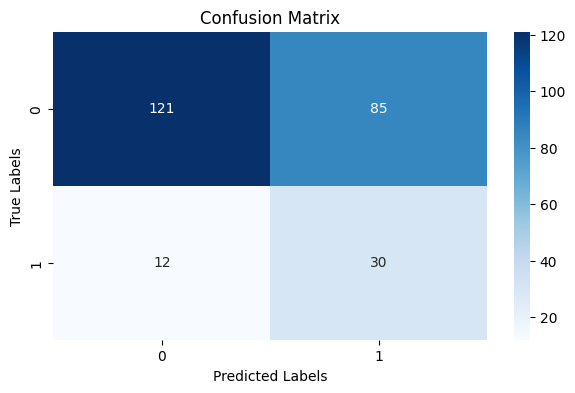

Precision: 0.2609, Recall: 0.7143, F1-Score: 0.3822
AUC-ROC: 0.5720
Epoch [28/100], Train Loss: 1.2409, Validation Loss: 2.1463, Accuracy: 60.89%


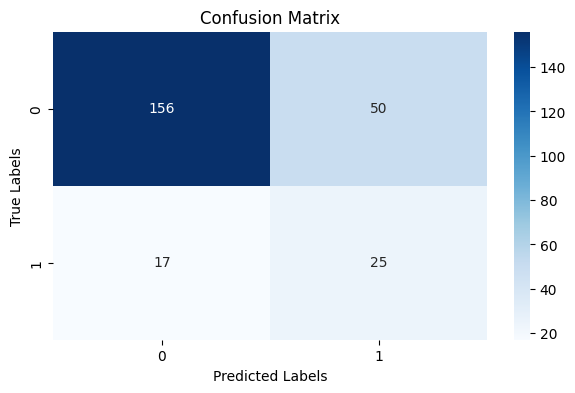

Precision: 0.3333, Recall: 0.5952, F1-Score: 0.4274
AUC-ROC: 0.4620
Epoch [29/100], Train Loss: 1.2650, Validation Loss: 1.4348, Accuracy: 72.98%


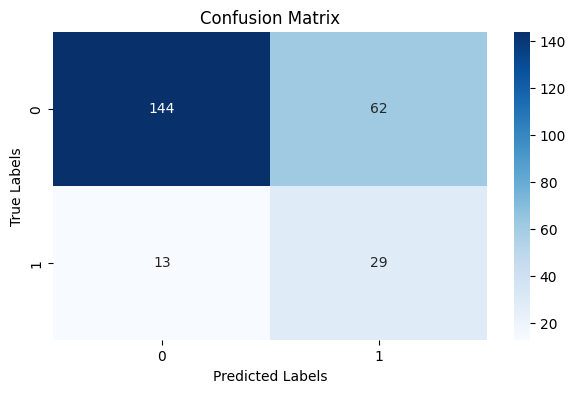

Precision: 0.3187, Recall: 0.6905, F1-Score: 0.4361
AUC-ROC: 0.5369
Epoch [30/100], Train Loss: 1.3202, Validation Loss: 1.6306, Accuracy: 69.76%


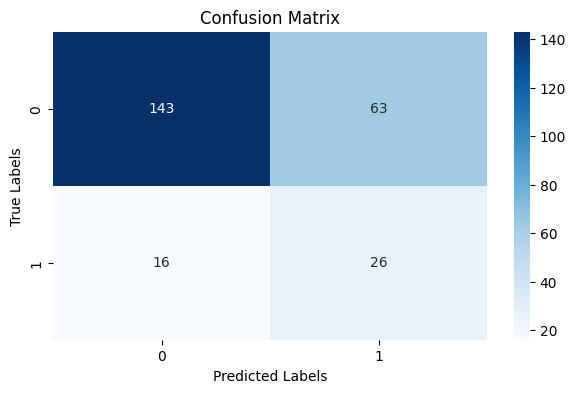

Precision: 0.2921, Recall: 0.6190, F1-Score: 0.3969
AUC-ROC: 0.4890
Epoch [31/100], Train Loss: 1.3597, Validation Loss: 1.7897, Accuracy: 68.15%


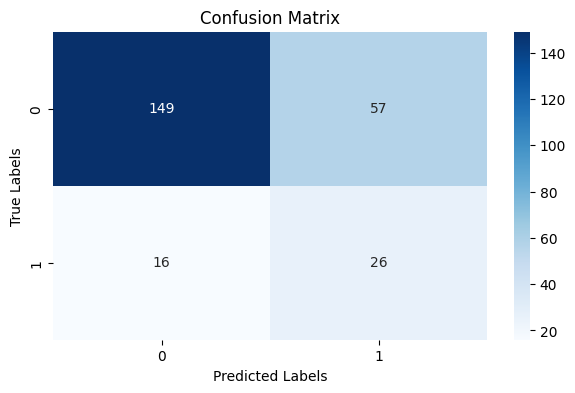

Precision: 0.3133, Recall: 0.6190, F1-Score: 0.4160
AUC-ROC: 0.4627
Epoch [32/100], Train Loss: 1.2568, Validation Loss: 1.5932, Accuracy: 70.56%


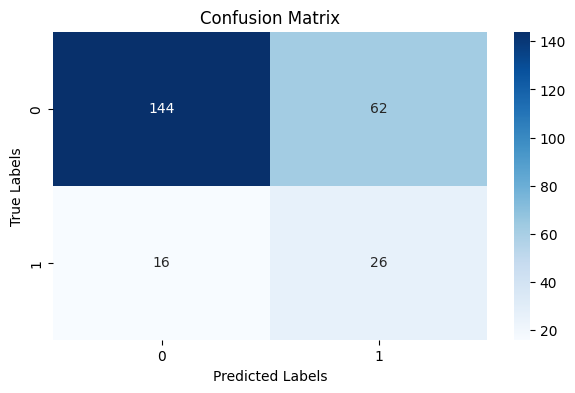

Precision: 0.2955, Recall: 0.6190, F1-Score: 0.4000
AUC-ROC: 0.4950
Epoch [33/100], Train Loss: 1.1462, Validation Loss: 1.5513, Accuracy: 68.55%


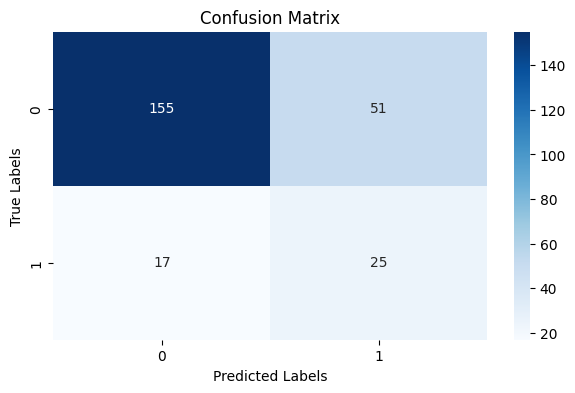

Precision: 0.3289, Recall: 0.5952, F1-Score: 0.4237
AUC-ROC: 0.5284
Epoch [34/100], Train Loss: 1.1822, Validation Loss: 1.3925, Accuracy: 72.58%


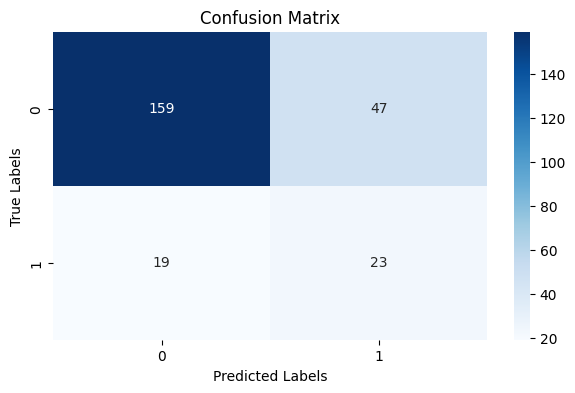

Precision: 0.3286, Recall: 0.5476, F1-Score: 0.4107
AUC-ROC: 0.3914
Epoch [35/100], Train Loss: 1.2328, Validation Loss: 1.1964, Accuracy: 73.39%


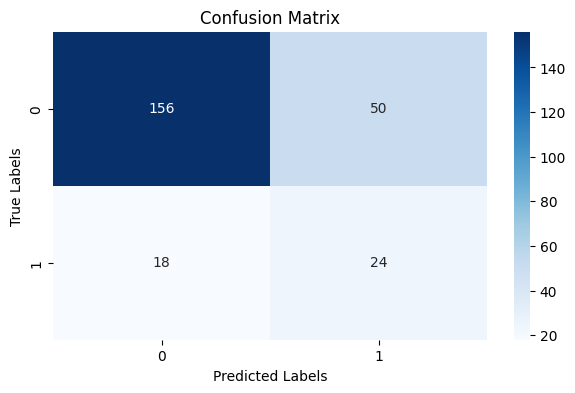

Precision: 0.3243, Recall: 0.5714, F1-Score: 0.4138
AUC-ROC: 0.5437
Epoch [36/100], Train Loss: 1.1401, Validation Loss: 1.4502, Accuracy: 72.58%


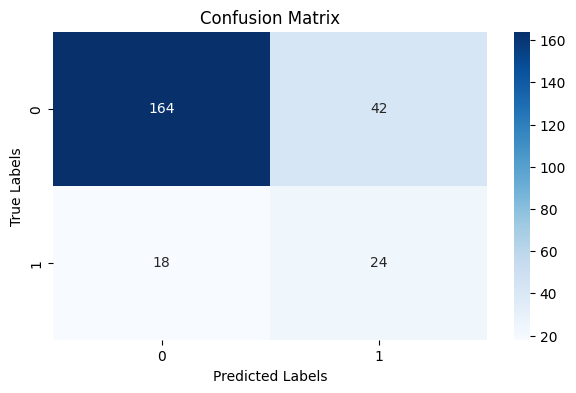

Precision: 0.3636, Recall: 0.5714, F1-Score: 0.4444
AUC-ROC: 0.5468
Epoch [37/100], Train Loss: 1.2970, Validation Loss: 1.2376, Accuracy: 75.81%


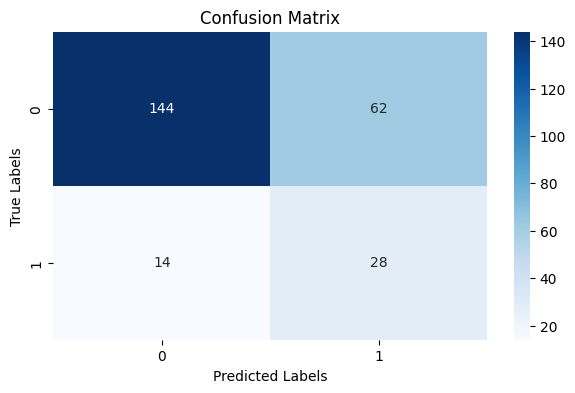

Precision: 0.3111, Recall: 0.6667, F1-Score: 0.4242
AUC-ROC: 0.5209
Epoch [38/100], Train Loss: 1.2609, Validation Loss: 1.4871, Accuracy: 69.35%


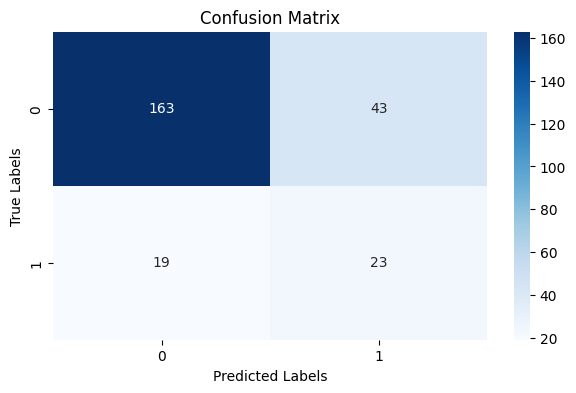

Precision: 0.3485, Recall: 0.5476, F1-Score: 0.4259
AUC-ROC: 0.5227
Epoch [39/100], Train Loss: 1.2131, Validation Loss: 1.2792, Accuracy: 75.00%


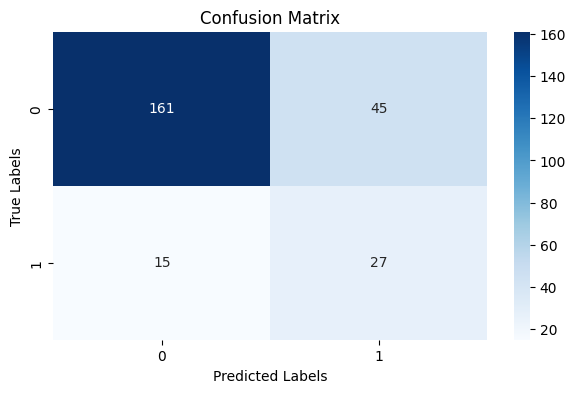

Precision: 0.3750, Recall: 0.6429, F1-Score: 0.4737
AUC-ROC: 0.5165
Epoch [40/100], Train Loss: 1.2185, Validation Loss: 1.3091, Accuracy: 75.81%


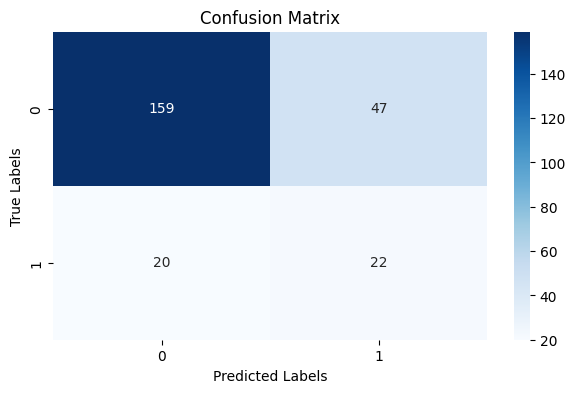

Precision: 0.3188, Recall: 0.5238, F1-Score: 0.3964
AUC-ROC: 0.4791
Epoch [41/100], Train Loss: 1.1484, Validation Loss: 1.3026, Accuracy: 72.98%


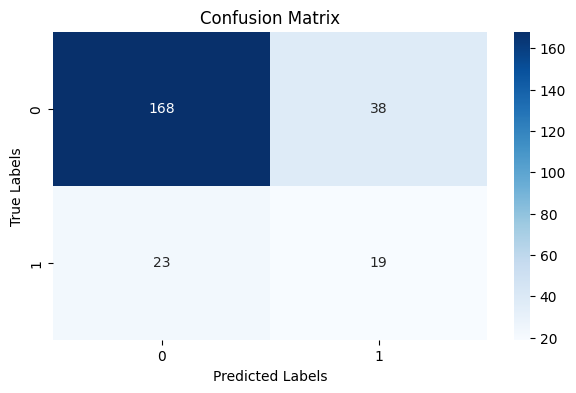

Precision: 0.3333, Recall: 0.4524, F1-Score: 0.3838
AUC-ROC: 0.5149
Epoch [42/100], Train Loss: 1.3007, Validation Loss: 1.0940, Accuracy: 75.40%


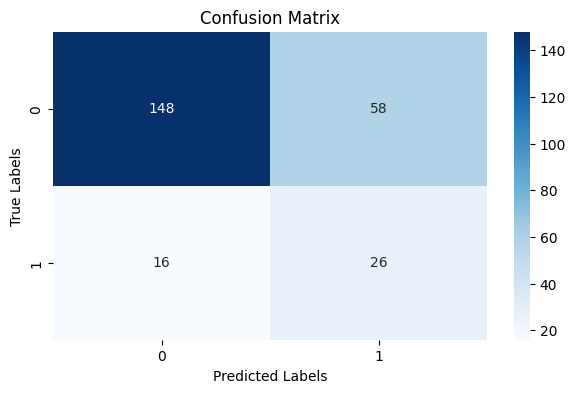

Precision: 0.3095, Recall: 0.6190, F1-Score: 0.4127
AUC-ROC: 0.4772
Epoch [43/100], Train Loss: 1.1751, Validation Loss: 1.5971, Accuracy: 70.16%


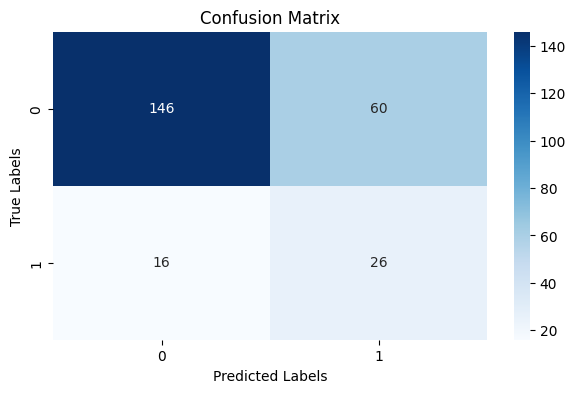

Precision: 0.3023, Recall: 0.6190, F1-Score: 0.4062
AUC-ROC: 0.5566
Epoch [44/100], Train Loss: 1.2505, Validation Loss: 1.5407, Accuracy: 69.35%


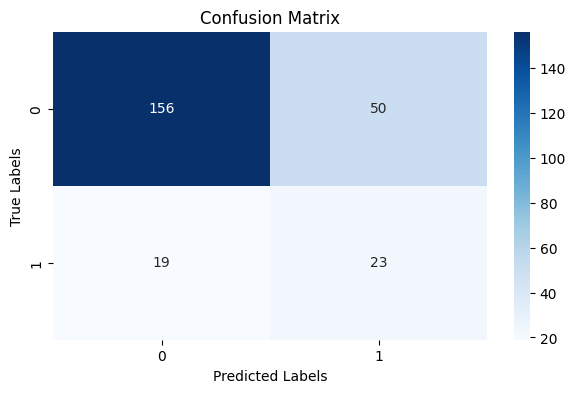

Precision: 0.3151, Recall: 0.5476, F1-Score: 0.4000
AUC-ROC: 0.5509
Epoch [45/100], Train Loss: 1.2935, Validation Loss: 1.3072, Accuracy: 72.18%


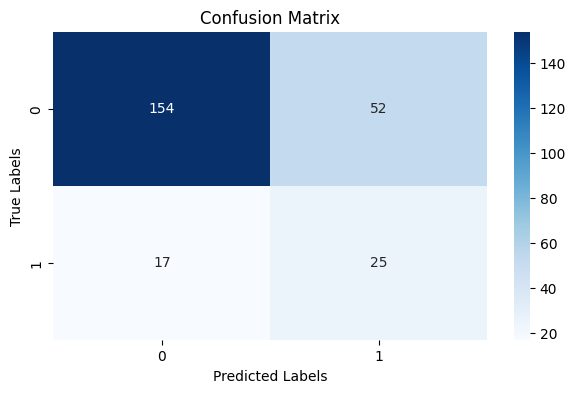

Precision: 0.3247, Recall: 0.5952, F1-Score: 0.4202
AUC-ROC: 0.4891
Epoch [46/100], Train Loss: 1.1029, Validation Loss: 1.7030, Accuracy: 72.18%


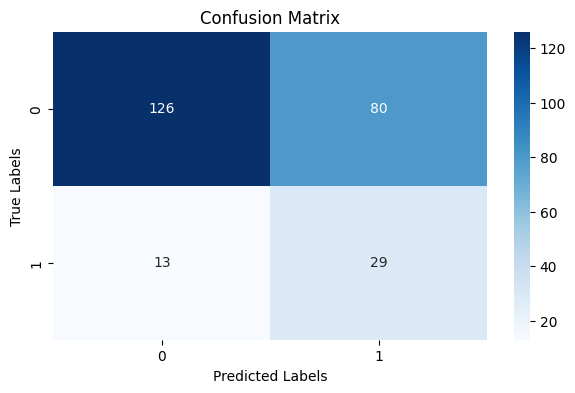

Precision: 0.2661, Recall: 0.6905, F1-Score: 0.3841
AUC-ROC: 0.5024
Epoch [47/100], Train Loss: 1.1517, Validation Loss: 2.1937, Accuracy: 62.50%


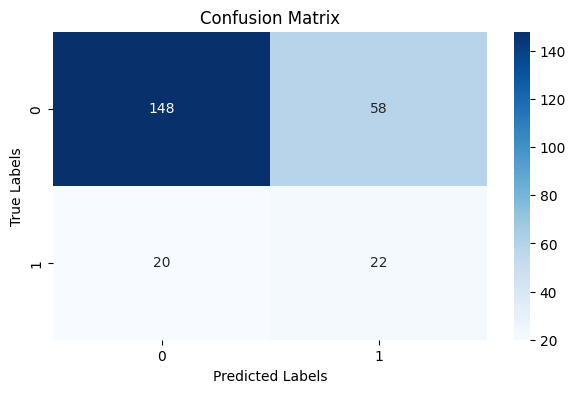

Precision: 0.2750, Recall: 0.5238, F1-Score: 0.3607
AUC-ROC: 0.4260
Epoch [48/100], Train Loss: 1.1772, Validation Loss: 1.3417, Accuracy: 68.55%


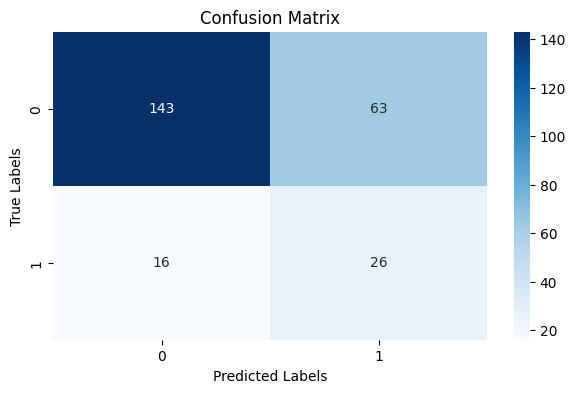

Precision: 0.2921, Recall: 0.6190, F1-Score: 0.3969
AUC-ROC: 0.4693
Epoch [49/100], Train Loss: 1.2611, Validation Loss: 1.6141, Accuracy: 68.15%


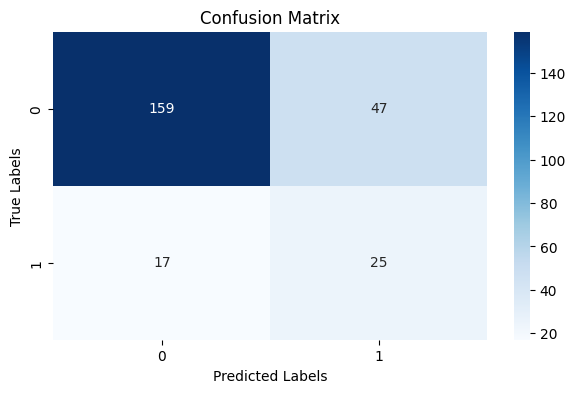

Precision: 0.3472, Recall: 0.5952, F1-Score: 0.4386
AUC-ROC: 0.4043
Epoch [50/100], Train Loss: 1.1185, Validation Loss: 1.3041, Accuracy: 74.19%


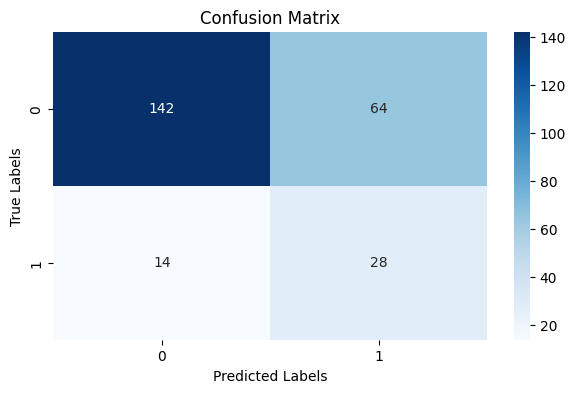

Precision: 0.3043, Recall: 0.6667, F1-Score: 0.4179
AUC-ROC: 0.5528
Epoch [51/100], Train Loss: 1.2134, Validation Loss: 1.5241, Accuracy: 68.55%


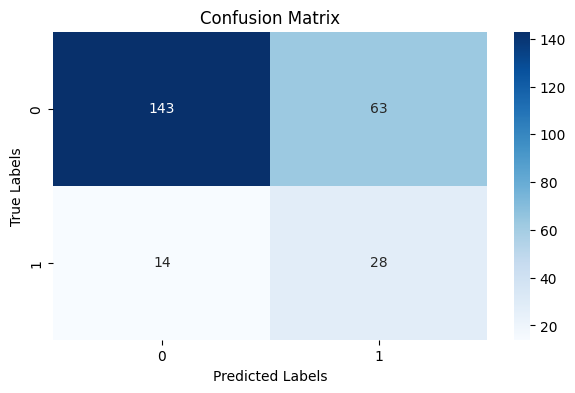

Precision: 0.3077, Recall: 0.6667, F1-Score: 0.4211
AUC-ROC: 0.5496
Epoch [52/100], Train Loss: 1.2180, Validation Loss: 1.4861, Accuracy: 68.95%


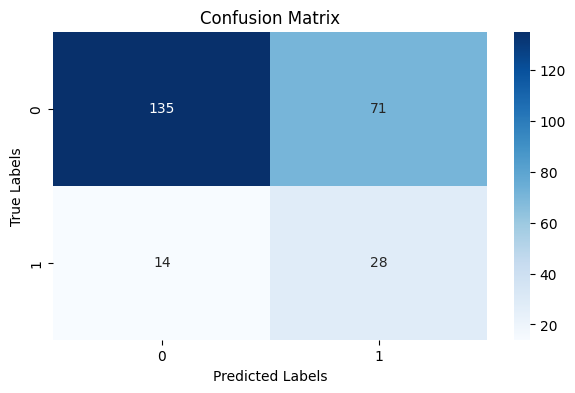

Precision: 0.2828, Recall: 0.6667, F1-Score: 0.3972
AUC-ROC: 0.4854
Epoch [53/100], Train Loss: 1.2448, Validation Loss: 1.8141, Accuracy: 65.73%


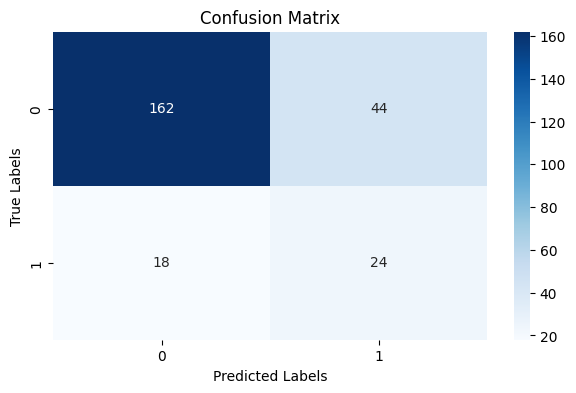

Precision: 0.3529, Recall: 0.5714, F1-Score: 0.4364
AUC-ROC: 0.5235
Epoch [54/100], Train Loss: 1.2019, Validation Loss: 1.1663, Accuracy: 75.00%


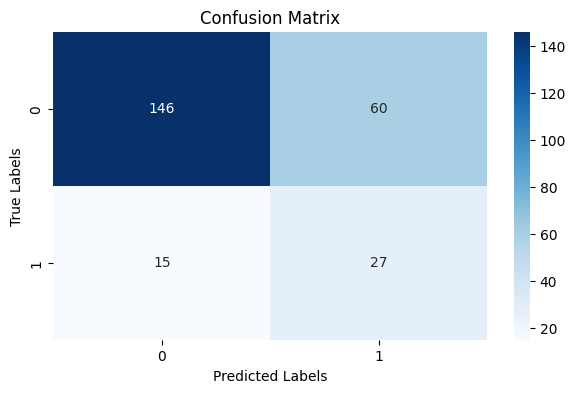

Precision: 0.3103, Recall: 0.6429, F1-Score: 0.4186
AUC-ROC: 0.4760
Epoch [55/100], Train Loss: 1.1873, Validation Loss: 1.4929, Accuracy: 69.76%


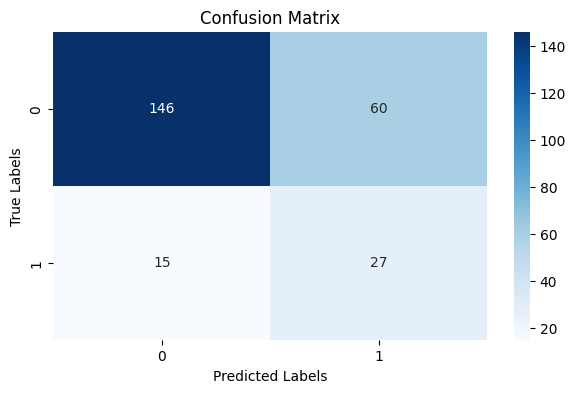

Precision: 0.3103, Recall: 0.6429, F1-Score: 0.4186
AUC-ROC: 0.5348
Epoch [56/100], Train Loss: 1.0350, Validation Loss: 1.5945, Accuracy: 69.76%


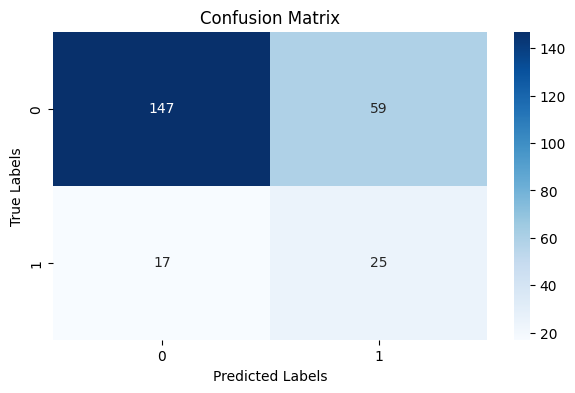

Precision: 0.2976, Recall: 0.5952, F1-Score: 0.3968
AUC-ROC: 0.4775
Epoch [57/100], Train Loss: 1.2407, Validation Loss: 1.5657, Accuracy: 69.35%


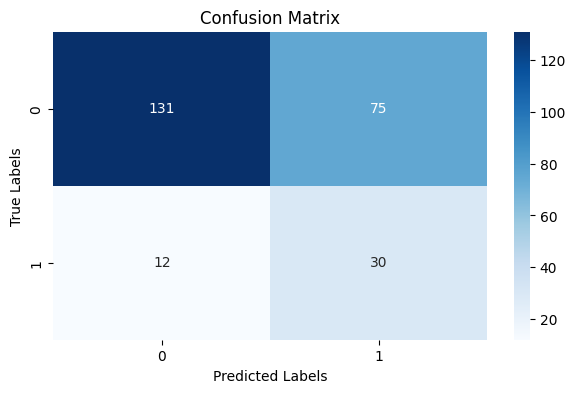

Precision: 0.2857, Recall: 0.7143, F1-Score: 0.4082
AUC-ROC: 0.4873
Epoch [58/100], Train Loss: 1.1657, Validation Loss: 1.9231, Accuracy: 64.92%


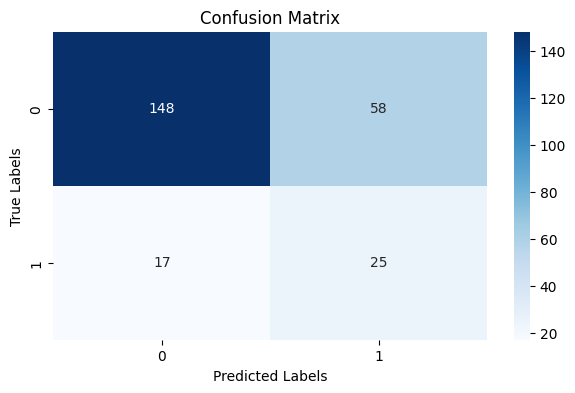

Precision: 0.3012, Recall: 0.5952, F1-Score: 0.4000
AUC-ROC: 0.5803
Epoch [59/100], Train Loss: 1.1845, Validation Loss: 1.6143, Accuracy: 69.76%


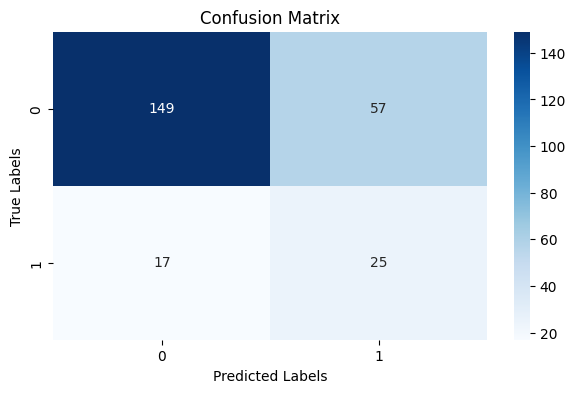

Precision: 0.3049, Recall: 0.5952, F1-Score: 0.4032
AUC-ROC: 0.4515
Epoch [60/100], Train Loss: 1.2375, Validation Loss: 1.6701, Accuracy: 70.16%


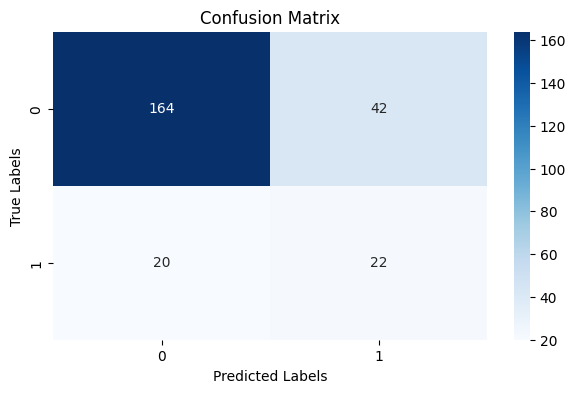

Precision: 0.3438, Recall: 0.5238, F1-Score: 0.4151
AUC-ROC: 0.4175
Epoch [61/100], Train Loss: 1.1728, Validation Loss: 1.2205, Accuracy: 75.00%


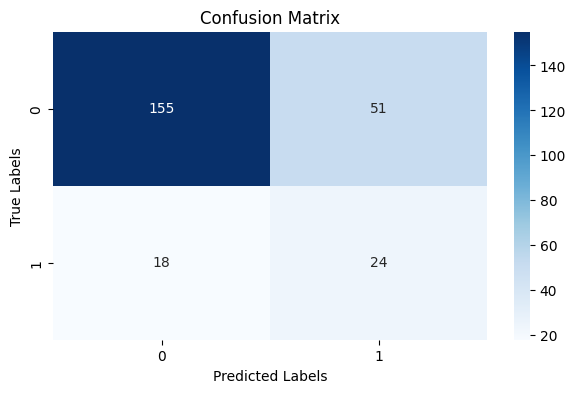

Precision: 0.3200, Recall: 0.5714, F1-Score: 0.4103
AUC-ROC: 0.4813
Epoch [62/100], Train Loss: 1.1143, Validation Loss: 1.4678, Accuracy: 72.18%


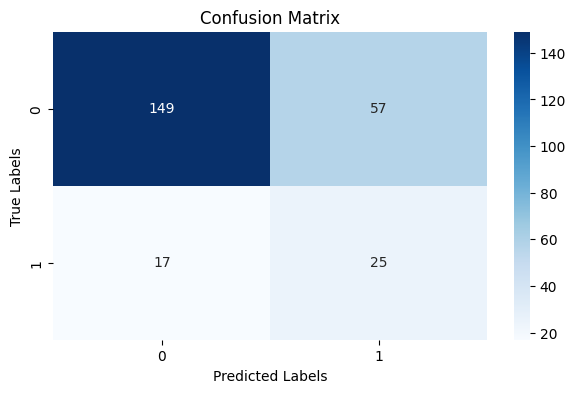

Precision: 0.3049, Recall: 0.5952, F1-Score: 0.4032
AUC-ROC: 0.4983
Epoch [63/100], Train Loss: 1.1812, Validation Loss: 1.2488, Accuracy: 70.16%


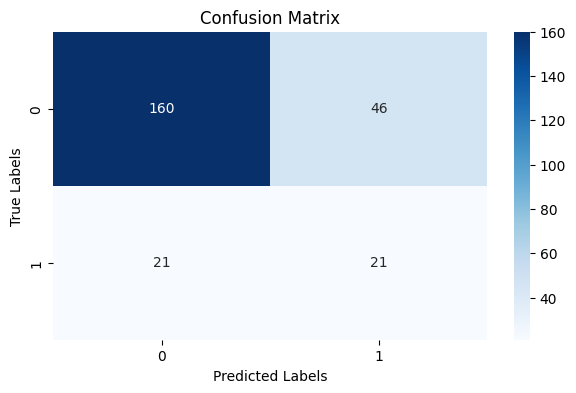

Precision: 0.3134, Recall: 0.5000, F1-Score: 0.3853
AUC-ROC: 0.5239
Epoch [64/100], Train Loss: 1.1600, Validation Loss: 1.3348, Accuracy: 72.98%


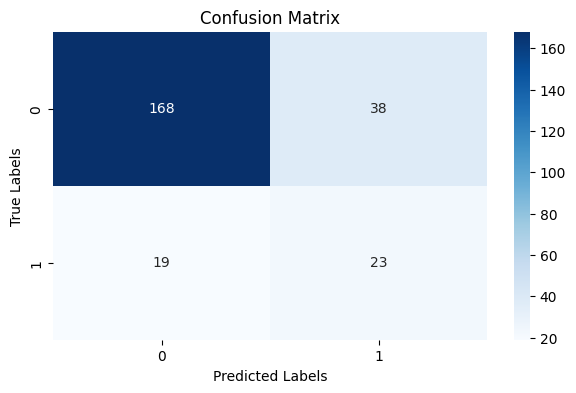

Precision: 0.3770, Recall: 0.5476, F1-Score: 0.4466
AUC-ROC: 0.4646
Epoch [65/100], Train Loss: 1.1186, Validation Loss: 1.1568, Accuracy: 77.02%


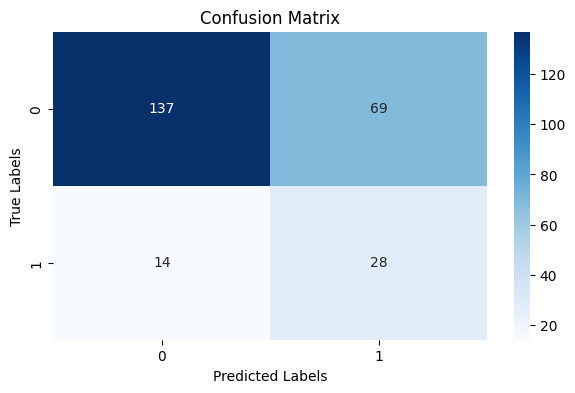

Precision: 0.2887, Recall: 0.6667, F1-Score: 0.4029
AUC-ROC: 0.5512
Epoch [66/100], Train Loss: 1.1089, Validation Loss: 1.6169, Accuracy: 66.53%


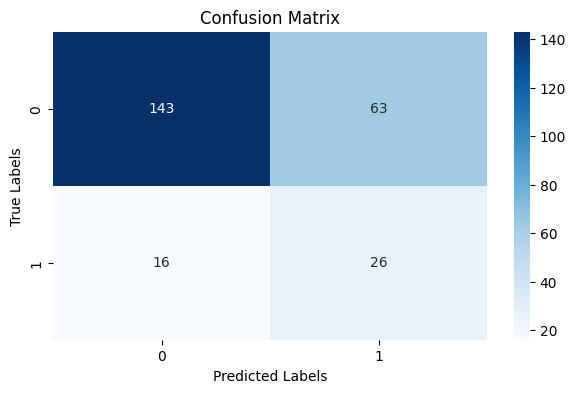

Precision: 0.2921, Recall: 0.6190, F1-Score: 0.3969
AUC-ROC: 0.5160
Epoch [67/100], Train Loss: 1.0840, Validation Loss: 1.7442, Accuracy: 68.15%


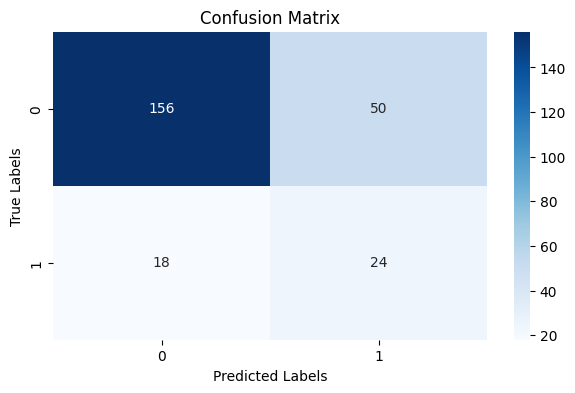

Precision: 0.3243, Recall: 0.5714, F1-Score: 0.4138
AUC-ROC: 0.6037
Epoch [68/100], Train Loss: 1.1614, Validation Loss: 1.4002, Accuracy: 72.58%


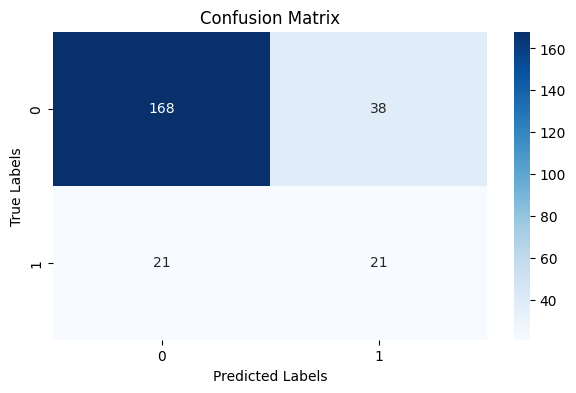

Precision: 0.3559, Recall: 0.5000, F1-Score: 0.4158
AUC-ROC: 0.5410
Epoch [69/100], Train Loss: 1.0915, Validation Loss: 1.2422, Accuracy: 76.21%


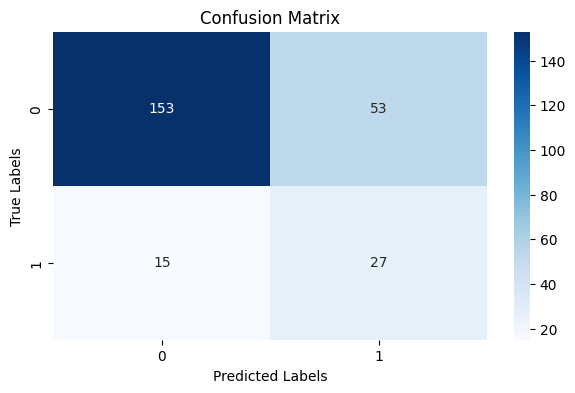

Precision: 0.3375, Recall: 0.6429, F1-Score: 0.4426
AUC-ROC: 0.5653
Epoch [70/100], Train Loss: 1.0710, Validation Loss: 1.4911, Accuracy: 72.58%


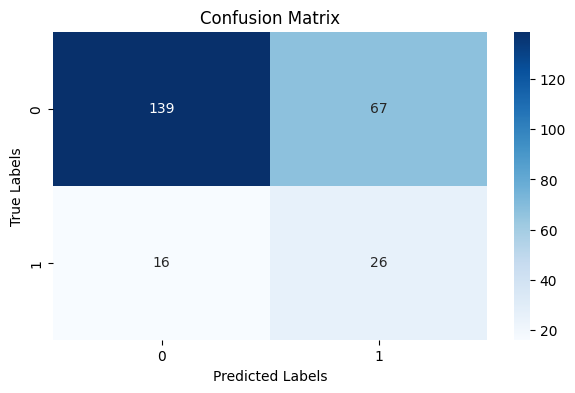

Precision: 0.2796, Recall: 0.6190, F1-Score: 0.3852
AUC-ROC: 0.4760
Epoch [71/100], Train Loss: 1.1394, Validation Loss: 1.6132, Accuracy: 66.53%


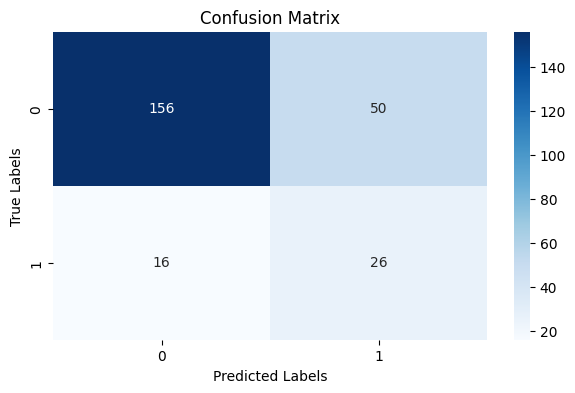

Precision: 0.3421, Recall: 0.6190, F1-Score: 0.4407
AUC-ROC: 0.4683
Epoch [72/100], Train Loss: 1.1858, Validation Loss: 1.4524, Accuracy: 73.39%


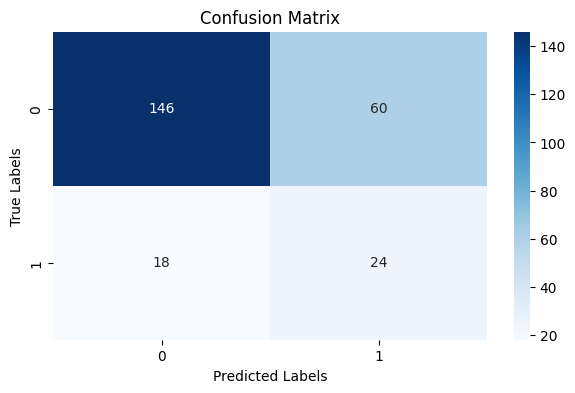

Precision: 0.2857, Recall: 0.5714, F1-Score: 0.3810
AUC-ROC: 0.5250
Epoch [73/100], Train Loss: 1.1217, Validation Loss: 1.5284, Accuracy: 68.55%


In [ ]:
for param in resnet.parameters():
    param.requires_grad = True

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.0000001, weight_decay=1e-3 )
num_epochs = 100
for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0
    for images, labels in train_loader:
        #print('iter')
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculando la pérdida promedio en la época
    train_loss /= len(train_loader)

    resnet.eval()
    validation_loss = 0
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # Obtén las predicciones binarias
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Guarda las predicciones y etiquetas para la matriz de confusión
            # Importante: aplana los arrays para que sean 1D
            all_predicted.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    validation_loss /= len(test_loader)
    accuracy = 100 * correct / total
    
    # Convierte a arrays numpy para la matriz de confusión
    all_predicted = np.array(all_predicted)
    all_labels = np.array(all_labels)
    
    # Calculando la matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(7,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='binary')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    
    # Si quieres calcular el AUC-ROC (necesitas las probabilidades, no las etiquetas binarias)
    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = resnet(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
    
    auc_roc = roc_auc_score(all_labels, all_probs)
    print(f'AUC-ROC: {auc_roc:.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [18]:
print((predicted == labels))

tensor([[False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True]], device='cuda:0')
